In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, multilabel_confusion_matrix, precision_recall_curve, average_precision_score

In [3]:
# Load your cleaned data
df = pd.read_csv('train_clean.csv')

# Features and labels
X = df['clean_comment'].tolist()
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("TRAIN: ",len(X_train), "\nVAL  : ",len(X_val))

TRAIN:  45430 
VAL  :  11358


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 150  # Same length we used before

In [5]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.comments)
    
    def __getitem__(self, item):
        comment = str(self.comments[item])
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)  # multi-label = float
        }

In [6]:
# Create DataLoaders
# -----------------------------------------------------
BATCH_SIZE = 16

train_dataset = ToxicCommentsDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset   = ToxicCommentsDataset(X_val, y_val, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [11]:
# Load model
# -----------------------------------------------------
BERTmodel = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=6,  # 6 labels
    problem_type="multi_label_classification"
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BERTmodel.to(device)
optimizer = AdamW(BERTmodel.parameters(), lr=2e-5, weight_decay=0.01)


EPOCHS = 3

num_training_steps = len(train_loader) * EPOCHS

# This linearly decreases the learning rate during training for better convergence.
lr_scheduler = get_scheduler(
    name="linear",  # or cosine
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

for epoch in range(EPOCHS):
    BERTmodel.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = BERTmodel(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
    
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {avg_train_loss:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|█████████████████████| 2840/2840 [04:24<00:00, 10.73it/s]


Epoch 1/3, Training Loss: 0.0620


Training Epoch 3: 100%|█████████████████████| 2840/2840 [04:21<00:00, 10.85it/s]

Epoch 3/3, Training Loss: 0.0275


In [12]:
# Evaluate
# -----------------------------------------------------
BERTmodel.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = BERTmodel(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.sigmoid(outputs.logits)
        
        predictions.append(preds.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

# Stack batches
y_pred = np.vstack(predictions)
y_true = np.vstack(true_labels)

# Threshold
y_pred = (y_pred > 0.5).astype(int)

# Report
print(classification_report(y_true, y_pred, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']))

               precision    recall  f1-score   support

        toxic       0.83      0.79      0.81      1130
 severe_toxic       0.56      0.45      0.50       111
      obscene       0.81      0.82      0.82       591
       threat       0.75      0.18      0.29        33
       insult       0.73      0.71      0.72       546
identity_hate       0.72      0.44      0.55       113

    micro avg       0.79      0.74      0.77      2524
    macro avg       0.73      0.57      0.61      2524
 weighted avg       0.79      0.74      0.76      2524
  samples avg       0.07      0.07      0.07      2524



/mmfs1/project/phan/tn268/RAG/ragenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mmfs1/project/phan/tn268/RAG/ragenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mmfs1/project/phan/tn268/RAG/ragenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

In [13]:
# Save model
BERTmodel.save_pretrained("models/bert_toxic_cmt_model")
tokenizer.save_pretrained("models/bert_toxic_cmt_model")


('models/bert_toxic_cmt_model/tokenizer_config.json',
 'models/bert_toxic_cmt_model/special_tokens_map.json',
 'models/bert_toxic_cmt_model/vocab.txt',
 'models/bert_toxic_cmt_model/added_tokens.json')

✅ Good points:

The model detects toxic, obscene, and insult categories quite well.

Overall F1 (~0.77 micro, 0.76 weighted) is strong for multi-label text classification.

Precision is generally higher than recall → means when it predicts positive, it’s often right.

⚠️ Areas for concern:

Recall is very low for threat (0.18) and severe_toxic (0.45).

Identity_hate is also struggling (F1 = 0.55).

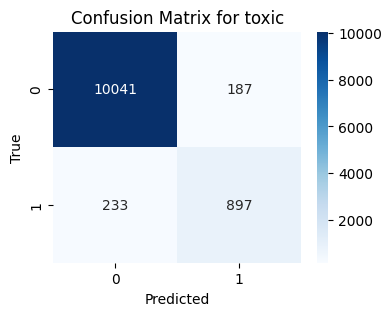

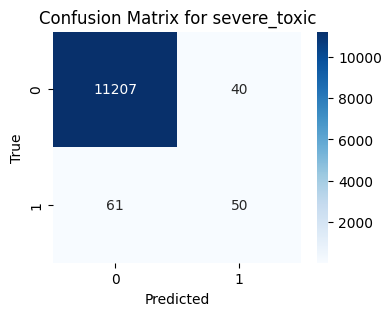

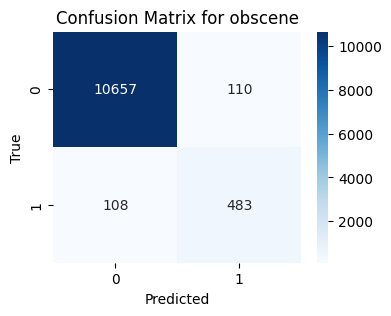

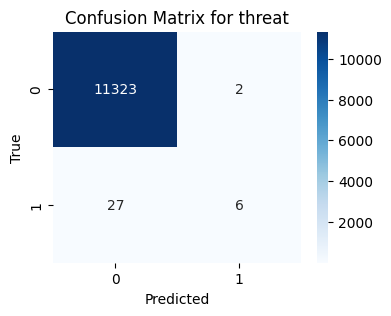

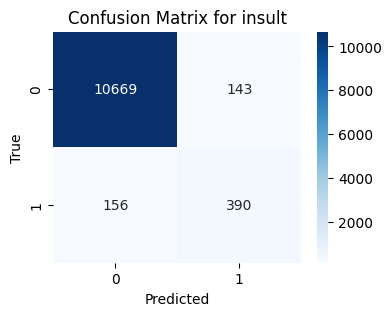

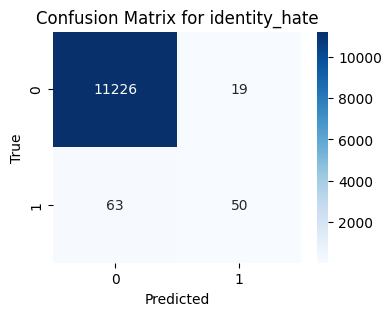

In [24]:
# Generate confusion matrix per class
cm = multilabel_confusion_matrix(y_true, y_pred)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Plot confusion matrix for each label
for i in range(len(labels)):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {labels[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

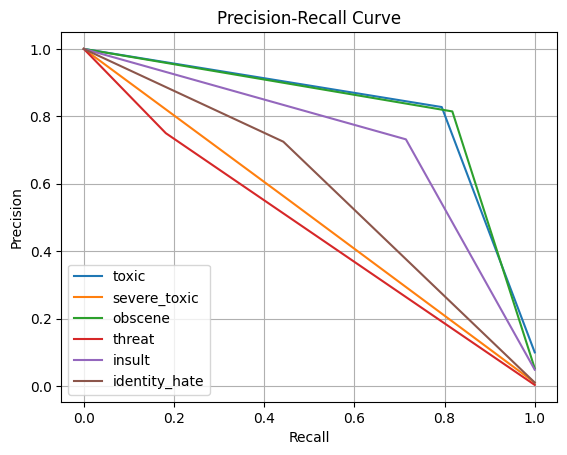

In [26]:
for i in range(len(labels)):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])

    plt.plot(recall, precision, label=f'{labels[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

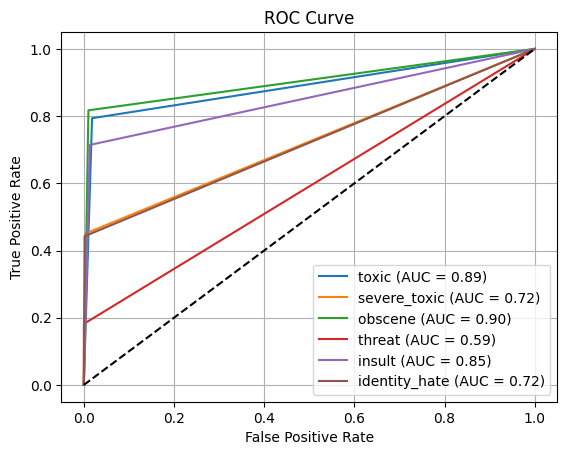

In [27]:
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [32]:
for i in range(len(labels)):
    score = average_precision_score(y_true[:, i], y_pred[:, i])
    print(f"{labels[i]} PR-AUC: {score:.3f}")

toxic PR-AUC: 0.677
severe_toxic PR-AUC: 0.256
obscene PR-AUC: 0.675
threat PR-AUC: 0.139
insult PR-AUC: 0.536
identity_hate PR-AUC: 0.326


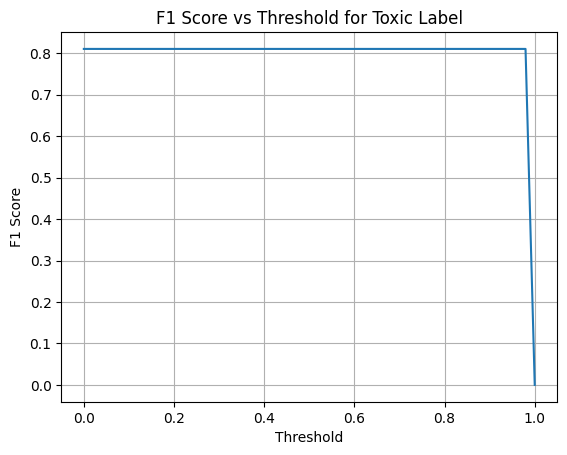

In [30]:
thresholds = np.linspace(0, 1, 50)
f1_scores = []

for threshold in thresholds:
    y_pred_bin = (y_pred[:, 0] > threshold).astype(int)  # For first label, e.g., 'toxic'
    f1 = f1_score(y_true[:, 0], y_pred_bin)
    f1_scores.append(f1)

plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold for Toxic Label')
plt.grid()
plt.show()